In [97]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from numba import jit

g: float = 9.81
l: float = 1.000
theta0: float = np.pi / 4.0
phi0: float = 0.00
theta_dot0: float = 0.00
phi_dot0: float = 1.00
t_span: tuple[float, float] = (0.0, 10.0)
t_eval: np.ndarray = np.linspace(0, 10, 1000)
metodo: str = "RK45"

In [98]:
def iniciar_variaveis_globais() -> None:
    """
    Função para iniciar as variáveis globais.
    g = 9.81 m/s²             # Aceleração da Gravidade
    l = 1.000 m               # Comprimento do pêndulo em metros
    theta0 = np.pi / 4        # Ângulo inicial em PI radianos = (45 graus)
    phi0 = 0.000              # Ângulo inicial em PI radianos = (0 graus)
    theta_dot0 = 0.000 rad/s  # Velocidade angular inicial em relação à direção vertical em radianos por segundo
    phi_dot0 = 1.000 rad/s    # Velocidade angular inicial em relação à direção horizontal em radianos por segundo
    """
    global g, l, theta0, phi0, theta_dot0, phi_dot0, t_span, t_eval, metodo

    def obter_valor(mensagem, valor_padrao, tipo=float, condicao=lambda x: True):
        """
        Função para obter e validar um valor inserido pelo usuário.
        """
        try:
            valor = input(mensagem)
            if valor == "":
                return valor_padrao
            else:
                valor_convertido = tipo(valor)
                if not condicao(valor_convertido):
                    raise ValueError
                return valor_convertido
        except ValueError:
            print(f"Valor inválido. Usando valor padrão: {valor_padrao}")
            return valor_padrao

    g = 9.81
    l = obter_valor("Digite o valor de l (em metros) [Enter para usar o valor padrão: 1.0]: ", 1.000, float, lambda x: x > 0)
    theta0 = obter_valor("Digite o ângulo inicial theta0 (em radianos) [Enter para usar o valor padrão: pi/4]: ", np.pi / 4.00, float)
    phi0 = obter_valor("Digite o ângulo inicial phi0 (em radianos) [Enter para usar o valor padrão: 0.0]: ", 0.000, float)
    theta_dot0 = obter_valor("Digite a velocidade angular inicial theta_dot0 (em rad/s) [Enter para usar o valor padrão: 0.0]: ", 0.000, float)
    phi_dot0 = obter_valor("Digite a velocidade angular inicial phi_dot0 (em rad/s) [Enter para usar o valor padrão: 1.0]: ", 1.000, float)
    total_segundos = obter_valor("Digite o total de segundos [Enter para usar o valor padrão: 10.0]: ", 10.0, float)
    t_span = (0.000, total_segundos)
    total_pontos = obter_valor("Digite o total de pontos [Enter para usar o valor padrão: 1000]: ", 1000, int)
    t_eval = np.linspace(0, total_segundos, total_pontos)
    metodo = obter_valor("Digite o método de integração [Enter para usar o valor padrão: RK45]: ", "RK45", str)

In [99]:
iniciar_variaveis_globais()
y0 = np.array([theta0, phi0, theta_dot0, phi_dot0])

Digite o valor de l (em metros) [Enter para usar o valor padrão: 1.0]: 
Digite o ângulo inicial theta0 (em radianos) [Enter para usar o valor padrão: pi/4]: 
Digite o ângulo inicial phi0 (em radianos) [Enter para usar o valor padrão: 0.0]: 
Digite a velocidade angular inicial theta_dot0 (em rad/s) [Enter para usar o valor padrão: 0.0]: 
Digite a velocidade angular inicial phi_dot0 (em rad/s) [Enter para usar o valor padrão: 1.0]: 
Digite o total de segundos [Enter para usar o valor padrão: 10.0]: 
Digite o total de pontos [Enter para usar o valor padrão: 1000]: 
Digite o método de integração [Enter para usar o valor padrão: RK45]: 


In [100]:
def pendulo_odes(t: float, y: np.ndarray) -> list:
    """
    Equações diferenciais para o pêndulo esférico.

    Parâmetros:
    t : float
        Tempo.
    y : np.ndarray
        Array contendo [theta, phi, theta_dot, phi_dot].

    Retorna:
        Lista com [theta_dot, phi_dot, theta_ddot, phi_ddot].
    """
    theta, phi, theta_dot, phi_dot = y
    theta_ddot = (phi_dot**2 * np.sin(theta) * np.cos(theta) - (g / l) * np.sin(theta))
    phi_ddot = (-2 * theta_dot * phi_dot * np.cos(theta)) / np.sin(theta)
    return [theta_dot, phi_dot, theta_ddot, phi_ddot]

In [101]:
sol = solve_ivp(pendulo_odes, t_span, y0, t_eval=t_eval, method=metodo, rtol=1e-8, atol=1e-10)

In [102]:
def calcular_coordenadas(sol) -> tuple:
    """
    Função para calcular as coordenadas do pêndulo em relação à origem.
    """
    theta, phi, theta_dot, phi_dot = sol.y
    x = l * np.sin(theta) * np.cos(phi)
    y = l * np.sin(theta) * np.sin(phi)
    z = l * np.cos(theta)
    return x, y, z

In [103]:
def calcular_residuo(x: np.ndarray, y: np.ndarray, z: np.ndarray, l: float) -> np.ndarray:
    """
    Calcula o resíduo da restrição do pêndulo esférico e retorna um np.ndarray com os valores do resíduo ao longo do tempo.
    """
    residuo = x**2 + y**2 + z**2 - l**2
    return residuo

In [104]:
residuo = calcular_residuo(x, y, z, l)

In [105]:
def animacao_pendulo(x, y, z, l):
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_xlim([-l, l])
    ax1.set_ylim([-l, l])
    ax1.set_zlim([0, 2*l])
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_zlabel('Z (m)')
    ax1.set_title('Animação do Pêndulo Esférico')

    line, = ax1.plot([], [], [], lw=2)

    def update(frame):
        line.set_data(x[:frame], y[:frame])
        line.set_3d_properties(z[:frame])
        return line,

    ani = FuncAnimation(fig, update, frames=len(x), interval=50, blit=True)
    HTML(ani.to_html5_video())

    # Plot do gráfico do resíduo
    ax2 = fig.add_subplot(122)
    ax2.plot(sol.t, residuo, label='Resíduo', color='b')
    ax2.axhline(0, color='k', linestyle='--', linewidth=0.8)  # Linha de referência zero
    ax2.set_xlabel('Tempo (s)')
    ax2.set_ylabel('Resíduo')
    ax2.set_title('Resíduo da Restrição do Pêndulo Esférico')
    ax2.grid(True)

    # Ajusta a escala do eixo y para melhor visualização
    ax2.set_ylim([-0.2, 0.2])

    plt.tight_layout()
    plt.show()

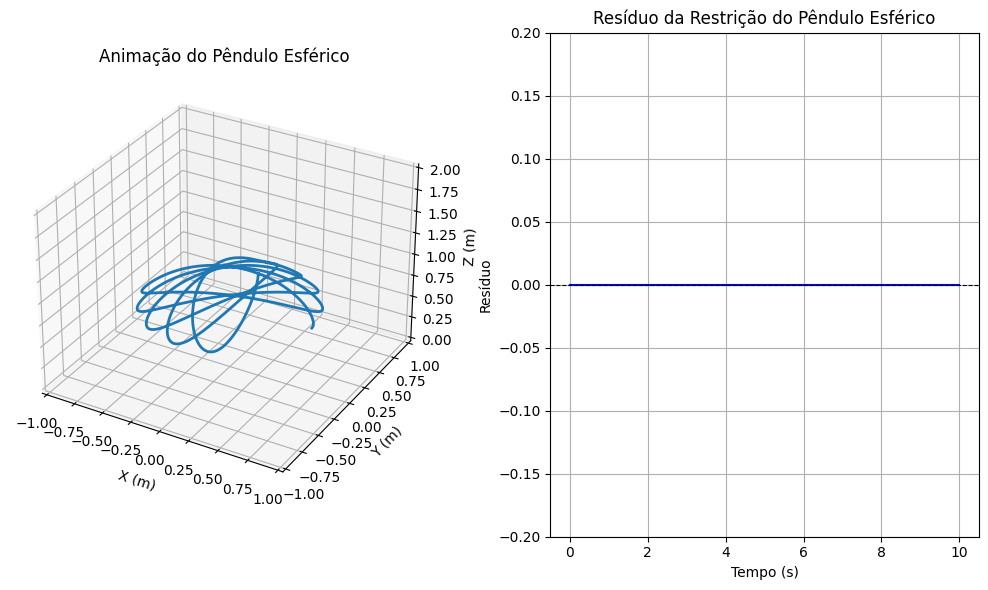

In [106]:
x, y, z = calcular_coordenadas(sol)
animacao_pendulo(x, y, z, l) # Demora para funcionar